In [30]:
import json
import torch
import random
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt

from tqdm import tqdm
from random import sample
from random import randint
from datetime import datetime
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
from sklearn.model_selection import train_test_split

In [2]:
!nvidia-smi

Tue Oct  1 06:19:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:87:00.0 Off |                    0 |
| N/A   32C    P0              65W / 400W |   1200MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [17]:
dir_root = "Data/"
output_qaa = f"{dir_root}qaa.json"
output_qaa_duplicated = f"{dir_root}qaa_duplicated"
dir_root, output_qaa, output_qaa_duplicated
name = "MedQuAD Super Expert"

### Sources

- https://huggingface.co/datasets/lavita/MedQuAD
- https://github.com/abachaa/MedQuAD/tree/master
  
```
@article{ben-abacha2019medquad,
    title     = {MedQuAD: A Medical Question Answering Dataset Containing Diverse Healthcare Topics},
    author    = {Ben Abacha, Asma and Demner-Fushman, Dina},
    journal   = {Studies in Health Technology and Informatics},
    year      = {2019},
    pages     = {307-311},
    publisher = {IOS Press}
}

@ARTICLE{BenAbacha-BMC-2019,    
    author    = {Asma {Ben Abacha} and Dina Demner{-}Fushman},
    title     = {A Question-Entailment Approach to Question Answering},
    journal   = {{BMC} Bioinform.}, 
    volume    = {20},
    number    = {1},
    pages     = {511:1--511:23},
    year      = {2019},
    url       = {https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3119-4}
}     
```

In [3]:
df_MedQuAD = pd.read_parquet("hf://datasets/lavita/MedQuAD/data/train-00000-of-00001-e36383d177026d53.parquet")
df_MedQuAD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47441 entries, 0 to 47440
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document_id          47436 non-null  object
 1   document_source      47441 non-null  object
 2   document_url         47441 non-null  object
 3   category             32010 non-null  object
 4   umls_cui             31417 non-null  object
 5   umls_semantic_types  31375 non-null  object
 6   umls_semantic_group  31417 non-null  object
 7   synonyms             24669 non-null  object
 8   question_id          47441 non-null  object
 9   question_focus       47427 non-null  object
 10  question_type        47441 non-null  object
 11  question             47441 non-null  object
 12  answer               16407 non-null  object
dtypes: object(13)
memory usage: 4.7+ MB


In [4]:
df_MedQuAD = df_MedQuAD[["question_focus", "question_type", "question", "answer"]]
df_MedQuAD = df_MedQuAD.dropna()
df_MedQuAD.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16393 entries, 0 to 34551
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_focus  16393 non-null  object
 1   question_type   16393 non-null  object
 2   question        16393 non-null  object
 3   answer          16393 non-null  object
dtypes: object(4)
memory usage: 640.4+ KB


In [5]:
vc_question_focus = df_MedQuAD["question_focus"].value_counts()
df_vc_question_focus = pd.DataFrame(vc_question_focus)
df_vc_question_focus.describe()

,count
count,5125.000000
mean,3.198634
std,3.019058
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,53.000000


In [6]:
df_MedQuAD = df_MedQuAD[df_MedQuAD['question_focus'].isin(vc_question_focus[vc_question_focus >= 3].index)]
df_MedQuAD.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13141 entries, 0 to 34550
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_focus  13141 non-null  object
 1   question_type   13141 non-null  object
 2   question        13141 non-null  object
 3   answer          13141 non-null  object
dtypes: object(4)
memory usage: 513.3+ KB


In [7]:
vc_question_type = df_MedQuAD["question_type"].value_counts()
df_vc_question_type = pd.DataFrame(vc_question_type)
print(df_vc_question_type.describe())

             count
count    16.000000
mean    821.312500
std     862.825646
min       1.000000
25%     221.500000
50%     519.500000
75%    1102.750000
max    3029.000000


In [8]:
df_MedQuAD = df_MedQuAD[df_MedQuAD['question_type'].isin(vc_question_type[vc_question_type >= 221].index)]
df_MedQuAD.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12815 entries, 0 to 34550
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_focus  12815 non-null  object
 1   question_type   12815 non-null  object
 2   question        12815 non-null  object
 3   answer          12815 non-null  object
dtypes: object(4)
memory usage: 500.6+ KB


In [11]:
tokenizer_opt = AutoTokenizer.from_pretrained("facebook/opt-6.7b")
tokenizer_gptj = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
tokenizer_llama = AutoTokenizer.from_pretrained("huggyllama/llama-7b")
tokenizer_llama2 = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

df_MedQuAD["wc"] = df_MedQuAD["answer"].apply(lambda x: len(x.split(" ")))
df_MedQuAD["t_opt_count"] = [len(tokenizer_opt(text,return_tensors="pt")["input_ids"][0]) for text in df_MedQuAD["answer"].values]
df_MedQuAD["t_gptj_count"] = [len(tokenizer_gptj(text,return_tensors="pt")["input_ids"][0]) for text in df_MedQuAD["answer"].values]
df_MedQuAD["t_llama_count"] = [len(tokenizer_llama(text,return_tensors="pt")["input_ids"][0]) for text in df_MedQuAD["answer"].values]
df_MedQuAD["t_llama2_count"] = [len(tokenizer_llama2(text,return_tensors="pt")["input_ids"][0]) for text in df_MedQuAD["answer"].values]
df_MedQuAD.describe()

Token indices sequence length is longer than the specified maximum sequence length for this model (2265 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2098 > 2048). Running this sequence through the model will result in indexing errors


,wc,t_opt_count,t_gptj_count,t_llama_count,t_llama2_count
count,12815.000000,12815.000000,12815.000000,12815.000000,12815.000000
mean,225.786968,294.308701,293.308701,310.842606,310.842606
std,392.538641,486.390672,486.390672,431.298059,431.298059
min,4.000000,6.000000,5.000000,7.000000,7.000000
25%,66.000000,89.000000,88.000000,105.000000,105.000000
50%,125.000000,168.000000,167.000000,195.000000,195.000000
75%,242.000000,319.000000,318.000000,358.000000,358.000000
max,6555.000000,9661.000000,9660.000000,8253.000000,8253.000000


In [32]:
df_MedQuAD = df_MedQuAD[
    (df_MedQuAD["wc"] <= 256) &
    (df_MedQuAD["t_llama2_count"] <= 256) & 
    (df_MedQuAD["t_llama_count"] <= 256) & 
    (df_MedQuAD["t_opt_count"] <= 256) & 
    (df_MedQuAD["t_gptj_count"] <= 256)]
df_MedQuAD = df_MedQuAD.reset_index(drop=True)
df_MedQuAD.describe()

,wc,t_opt_count,t_gptj_count,t_llama_count,t_llama2_count
count,7871.000000,7871.000000,7871.000000,7871.000000,7871.000000
mean,81.933681,109.027824,108.027824,126.988693,126.988693
std,43.864408,57.220382,57.220382,64.982079,64.982079
min,4.000000,6.000000,5.000000,7.000000,7.000000
25%,51.000000,60.000000,59.000000,69.000000,69.000000
50%,77.000000,104.000000,103.000000,122.000000,122.000000
75%,115.000000,153.000000,152.000000,178.000000,178.000000
max,226.000000,255.000000,254.000000,256.000000,256.000000


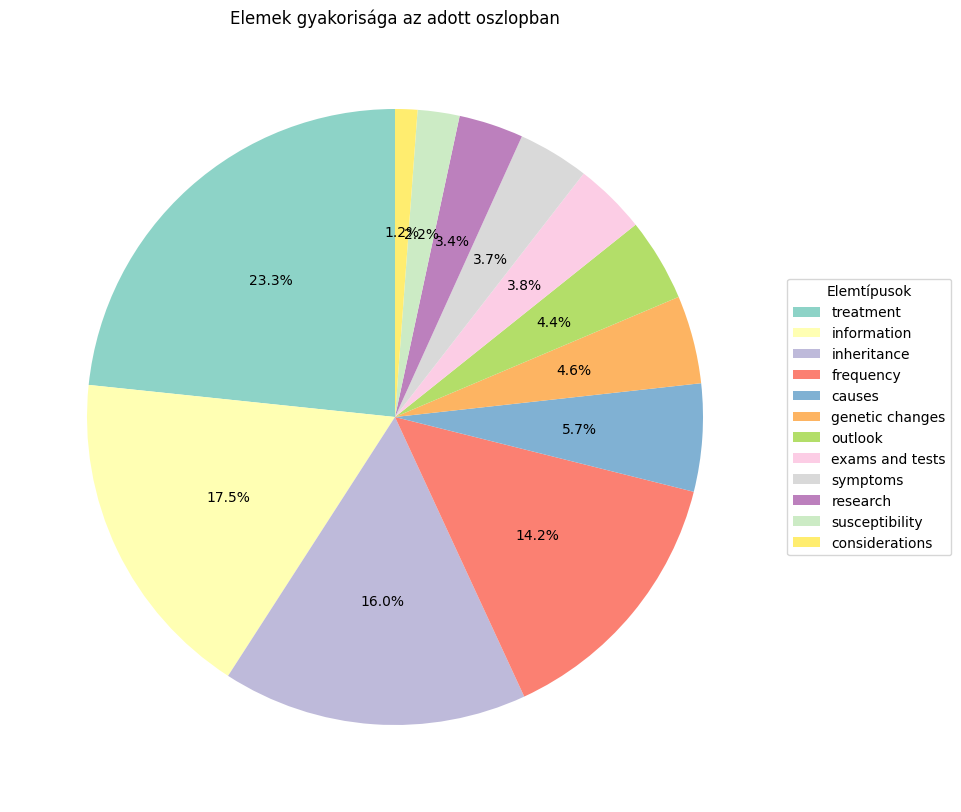

In [33]:
vc_question_type = df_MedQuAD["question_type"].value_counts()

# Pite diagram elkészítése
plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(vc_question_type, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)

# Diagram megjelenítése
plt.title('Elemek gyakorisága az adott oszlopban')
plt.legend(wedges, vc_question_type.index, title="Elemtípusok", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

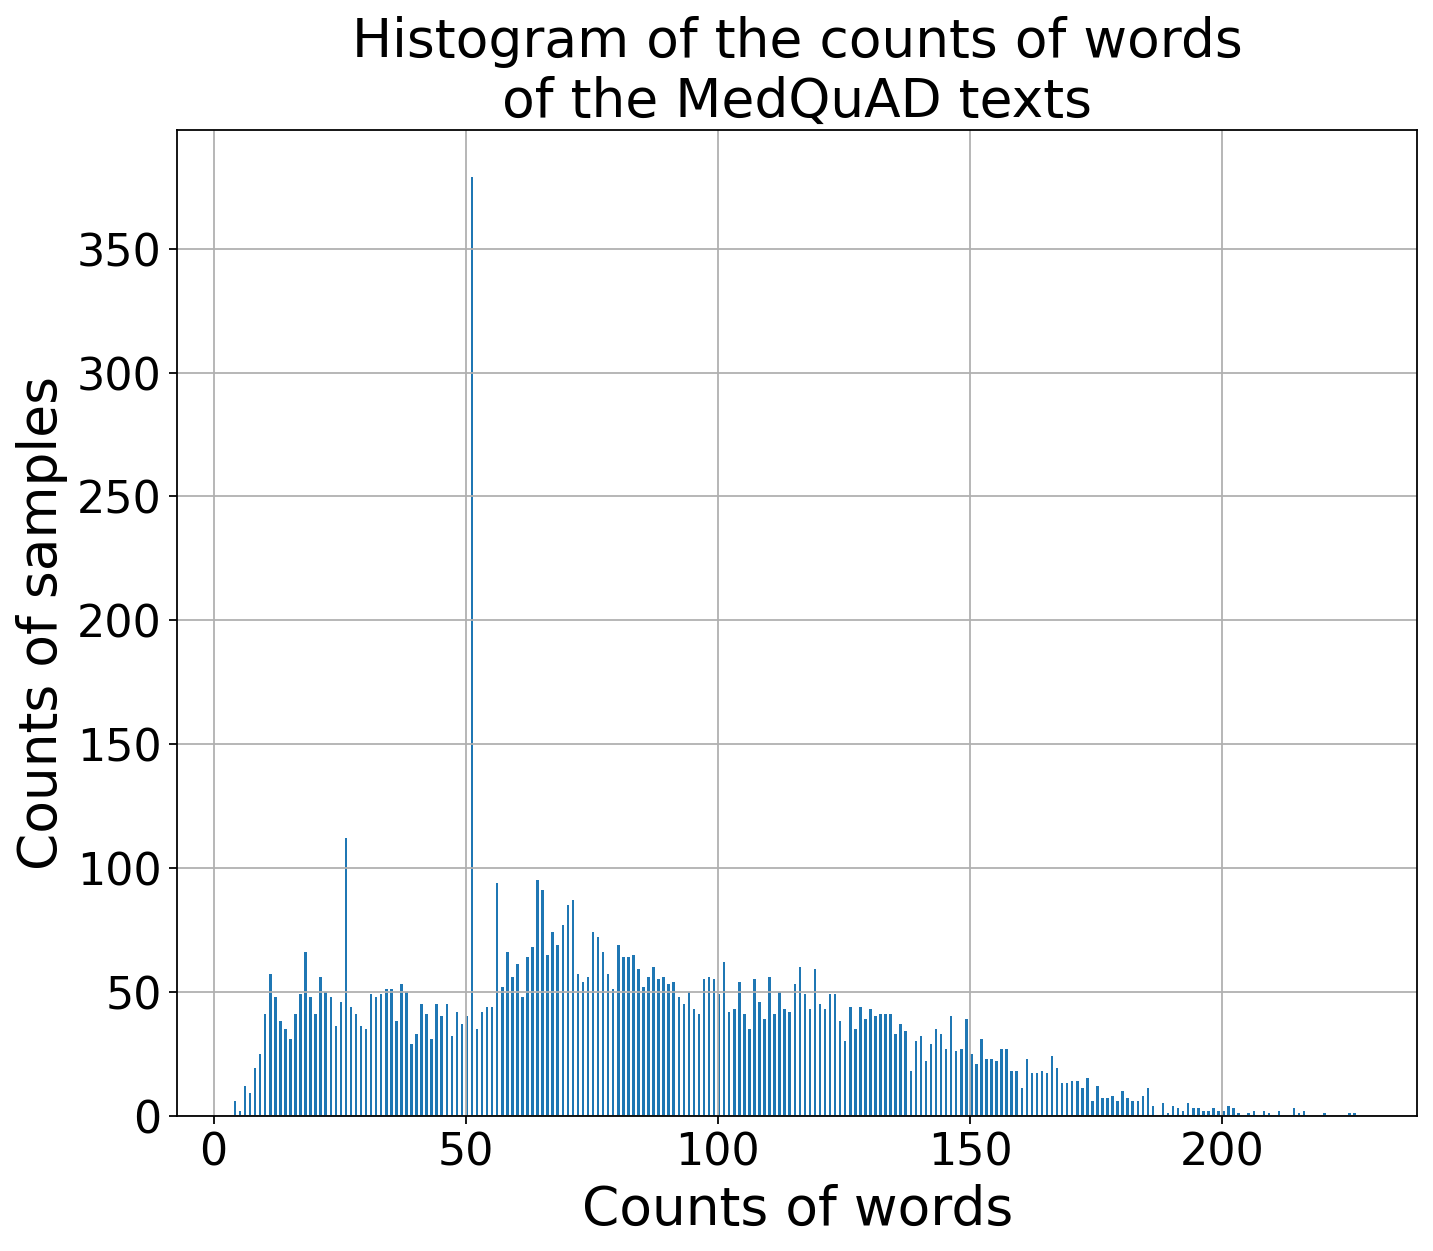

,wc,t_opt_count,t_gptj_count,t_llama_count,t_llama2_count
count,7871.000000,7871.000000,7871.000000,7871.000000,7871.000000
mean,81.933681,109.027824,108.027824,126.988693,126.988693
std,43.864408,57.220382,57.220382,64.982079,64.982079
min,4.000000,6.000000,5.000000,7.000000,7.000000
25%,51.000000,60.000000,59.000000,69.000000,69.000000
50%,77.000000,104.000000,103.000000,122.000000,122.000000
75%,115.000000,153.000000,152.000000,178.000000,178.000000
max,226.000000,255.000000,254.000000,256.000000,256.000000


In [34]:
plt.figure(figsize=(10, 8), dpi=160)
df_MedQuAD["wc"].hist(bins=[i for i in np.arange(df_MedQuAD["wc"].min(), df_MedQuAD["wc"].max() + 2, 0.5)])
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Counts of words', fontsize=24)
plt.ylabel('Counts of samples', fontsize=24)
plt.title("Histogram of the counts of words\nof the MedQuAD texts", fontsize=24)
plt.savefig('../images/wc_histogram_total_medquad.png')
plt.show()
df_MedQuAD.describe()

In [37]:
df_MedQuAD["name"] = [name] * len(df_MedQuAD)
df_MedQuAD.to_json("Data/qaa.json")
df_MedQuAD.head()

,question_focus,question_type,question,answer,wc,t_opt_count,t_gptj_count,t_llama_count,t_llama2_count,name
0,keratoderma with woolly hair,frequency,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is rare; its prev...,82,111,110,120,120,MedQuAD Super Expert
1,keratoderma with woolly hair,inheritance,Is keratoderma with woolly hair inherited ?,Most cases of keratoderma with woolly hair hav...,56,69,68,79,79,MedQuAD Super Expert
2,Knobloch syndrome,frequency,How many people are affected by Knobloch syndr...,Knobloch syndrome is a rare condition. However...,15,21,20,25,25,MedQuAD Super Expert
3,Knobloch syndrome,inheritance,Is Knobloch syndrome inherited ?,This condition is inherited in an autosomal re...,51,60,59,69,69,MedQuAD Super Expert
4,Knobloch syndrome,treatment,What are the treatments for Knobloch syndrome ?,These resources address the diagnosis or manag...,90,119,118,148,148,MedQuAD Super Expert


In [38]:
df_MedQuAD = pd.read_json("Data/qaa.json")
df_MedQuAD.head()

,question_focus,question_type,question,answer,wc,t_opt_count,t_gptj_count,t_llama_count,t_llama2_count,name
0,keratoderma with woolly hair,frequency,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is rare; its prev...,82,111,110,120,120,MedQuAD Super Expert
1,keratoderma with woolly hair,inheritance,Is keratoderma with woolly hair inherited ?,Most cases of keratoderma with woolly hair hav...,56,69,68,79,79,MedQuAD Super Expert
2,Knobloch syndrome,frequency,How many people are affected by Knobloch syndr...,Knobloch syndrome is a rare condition. However...,15,21,20,25,25,MedQuAD Super Expert
3,Knobloch syndrome,inheritance,Is Knobloch syndrome inherited ?,This condition is inherited in an autosomal re...,51,60,59,69,69,MedQuAD Super Expert
4,Knobloch syndrome,treatment,What are the treatments for Knobloch syndrome ?,These resources address the diagnosis or manag...,90,119,118,148,148,MedQuAD Super Expert


In [39]:
vc_question_type = df_MedQuAD["question_type"].value_counts()
df_vc_question_type = pd.DataFrame(vc_question_type)
print(df_vc_question_type.describe())

             count
count    12.000000
mean    655.916667
std     579.108321
min      92.000000
25%     287.250000
50%     353.500000
75%    1153.500000
max    1837.000000


In [40]:
df_vc_question_type["train"] = df_vc_question_type["count"].values * 0.8
df_vc_question_type["train"] = df_vc_question_type["train"].apply(lambda x: int(round(x,0)))
df_vc_question_type["test"] = df_vc_question_type["count"].values - df_vc_question_type["train"].values
df_vc_question_type

,count,train,test
question_type,,,
treatment,1837,1470,367
information,1381,1105,276
inheritance,1260,1008,252
frequency,1118,894,224
causes,445,356,89
genetic changes,364,291,73
outlook,343,274,69
exams and tests,297,238,59
symptoms,294,235,59


In [41]:
trains = []
tests = []
for item in df_vc_question_type.index:    
    tmp = df_MedQuAD[df_MedQuAD["question_type"] == item].copy()
    train, test = train_test_split(tmp, test_size=0.2)
    trains.append(train)
    tests.append(test)
    print(item, len(train), len(test))

treatment 1469 368
information 1104 277
inheritance 1008 252
frequency 894 224
causes 356 89
genetic changes 291 73
outlook 274 69
exams and tests 237 60
symptoms 235 59
research 213 54
susceptibility 138 35
considerations 73 19


In [42]:
trains = pd.concat(trains, ignore_index=True).sample(frac=1)
vals = pd.concat(tests, ignore_index=True).sample(frac=1)
tests = vals[:300]
vals = vals[300:]
print(trains.info())
print(vals.info())
print(tests.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6292 entries, 5617 to 1705
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_focus  6292 non-null   object
 1   question_type   6292 non-null   object
 2   question        6292 non-null   object
 3   answer          6292 non-null   object
 4   wc              6292 non-null   int64 
 5   t_opt_count     6292 non-null   int64 
 6   t_gptj_count    6292 non-null   int64 
 7   t_llama_count   6292 non-null   int64 
 8   t_llama2_count  6292 non-null   int64 
 9   name            6292 non-null   object
dtypes: int64(5), object(5)
memory usage: 540.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1279 entries, 138 to 447
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_focus  1279 non-null   object
 1   question_type   1279 non-null   object
 2   question        1279 non-n

### Alpaca Style

In [43]:
def alpaca_style(data, file_name):
    test_input = []
    test_output = []
    test_instruction =  []
    for i in range(len(data)):
        test_instruction.append(data["question"].values[i])
        test_output.append(data["answer"].values[i])
        test_input.append(data["name"].values[i])
    
    pd.DataFrame({"instruction" : test_instruction, "output" : test_output, "input" : test_input}).to_json(f"{dir_root}{file_name}", orient="records")
    print(len(test_input), len(test_output), len(test_instruction))

alpaca_style(trains, "qaa_train.json")
alpaca_style(vals, "qaa_val.json")
alpaca_style(tests, "qaa_test.json")

6292 6292 6292
1279 1279 1279
300 300 300


### Llama (Context) Style

In [44]:
with open(f"{dir_root}qaa_train.json","r") as f:
    train_base = json.load(f)

with open(f"{dir_root}qaa_val.json","r") as f:
    val_base = json.load(f)
    
len(train_base), len(val_base)

(6292, 1279)

In [45]:
def context_style(data, file_name):
    result = []
    for item in tqdm(data):
        new_item_with_context = item.copy()
        new_item_without_context = item.copy()
        
        context = sample(train_base, 5)
        context.insert(randint(0, 4), item)
        context = "\n".join([t["output"] for t in context])
        
        new_item_with_context["context"] = context
        new_item_without_context["context"] = ""
    
        result.append(new_item_with_context)
        result.append(new_item_without_context)

    pd.DataFrame(result).to_json(f"{dir_root}{file_name}", orient="records")
    print(len(result))

context_style(train_base, "qaa_train_context.json")
context_style(val_base, "qaa_val_context.json")

100% 6292/6292 [00:00<00:00, 10528.54it/s]


12584


100% 1279/1279 [00:00<00:00, 123866.05it/s]

2558
